In [6]:
from pathlib import Path 
import pandas as pd 
import random
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import numpy as np

In [18]:
g_file_names = list() 

target = "3ca7"
job_name = "61_sb_4"

xray_dir = Path(Path.home(), "Documents/xray")
log_stats_dir = Path(xray_dir, "sample_bench/data", target)

xray_stat_df = pd.read_csv(Path(log_stats_dir, job_name, "sample_bench_xray_0.csv"), index_col=0)
rmsd_stat_df = pd.read_csv(Path(log_stats_dir, job_name, "sample_bench_rmsd.csv"), index_col=0)

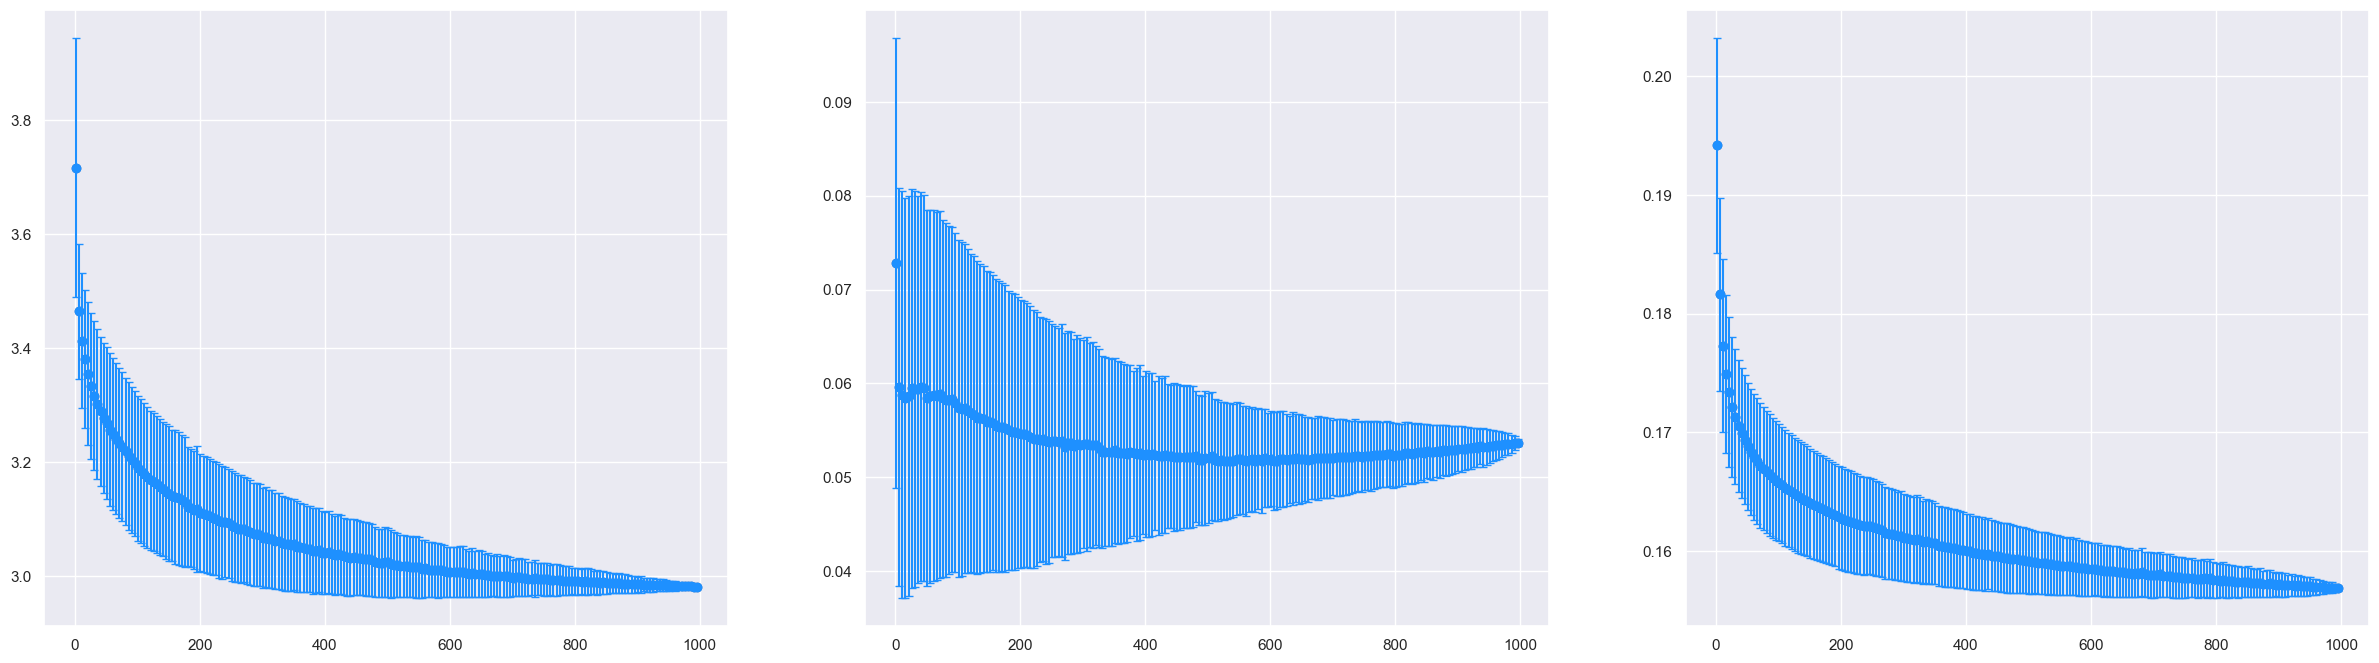

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(30,8))

colors = list() 
colors.append(mcolors.CSS4_COLORS["dodgerblue"])
colors.append(mcolors.CSS4_COLORS["orange"])
colors.append(mcolors.CSS4_COLORS["orangered"])

alpha = .5
space = 5

x = xray_stat_df.index[::space]

y1 = xray_stat_df["xray_0_mean"][::space]
std1 = xray_stat_df["xray_0_std"][::space]

y2 = xray_stat_df["rmsd_avg_mean"][::space]
std2 = xray_stat_df["rmsd_avg_std"][::space]

y3 = rmsd_stat_df["rmsd_mean"][::space]
std3 = rmsd_stat_df["rmsd_std"][::space]

ax1 = axs[0]
ax1.scatter(x, y1)
ax1.errorbar(x, y1, std1, linestyle='None', marker='o', capsize=3, c=colors[0])

ax2 = axs[1]
ax2.scatter(x, y2)
ax2.errorbar(x, y2, std2, linestyle='None', marker='o', capsize=3, c=colors[0])

ax3 = axs[2]
ax3.scatter(x, y3)
ax3.errorbar(x, y3, std3, linestyle='None', marker='o', capsize=3, c=colors[0])

plt.savefig(Path(Path.home(), "Desktop/sample_volume_benchmark.png"))


